In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v011.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, tqdm
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

Using backend: pytorch



True

## Process images for a single patient

- load SITK images from NIFTI files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [35]:
%autoreload
patient = mre_pinn.data.ImagingPatient('0006')
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii


size    spacing      origin       limit      center  \
sequence     dimension                                                        
t1_pre_in    0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_water 0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_out   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_fat   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t2           0           256   1.406300 -200.263000  158.343486  -20.959757   
             1           256   1.406300 -208.240997  150.365490  -28.937754   
             2            23  10.000000 -154.516006   65.483994  -44.516006   
mre_raw      0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4   1.000000    0.000000    3.000000    1.500000   
wave         0           512   1.000000    0.000000  511.000000  255.500000   
             1           512   1.000000    0.000000  511.000000  255.500000   
             2             4   1.000000    0.000000    3.000000    1.500000   
mre          0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4  11.000000   -1.056400   31.943600   15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2            4.000000  
wave         0          512.000000  
             1          512.000000  
             2            4.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

In [36]:
%autoreload
patient.preprocess_images()

Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600f61b2fd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1411146
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
 

In [37]:
patient.metadata

size    spacing      origin       limit     center  \
sequence     dimension                                                       
t1_pre_in    0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
t1_pre_water 0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
t1_pre_out   0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
t1_pre_fat   0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
t2           0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
mre_raw      0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
wave         0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
mre          0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
anat_mask    0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
mre_mask     0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          359.987213  
             1          359.987213  
             2          202.400269  
mre_raw      0          360.012787  
             1          360.012787  
             2           44.000000  
wave         0          360.012787  
             1          360.012787  
             2           44.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000  
anat_mask    0          359.987213  
             1          359.987213  
             2          202.400269  
mre_mask     0          360.012787  
             1          360.012787  
             2           44.000000

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray


<IPython.core.display.Javascript object>


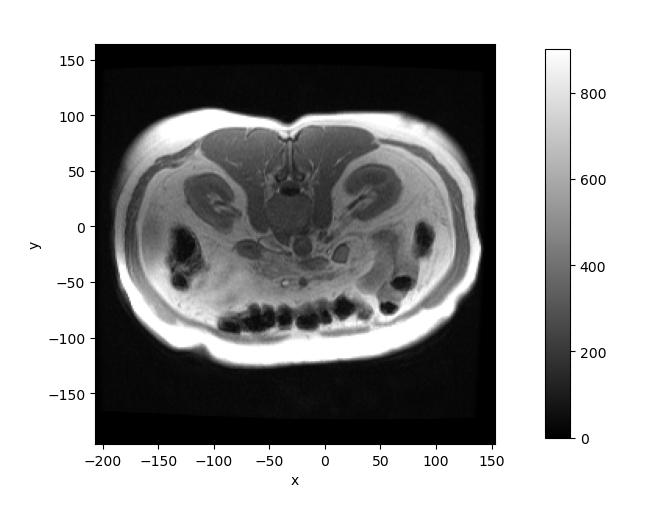

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


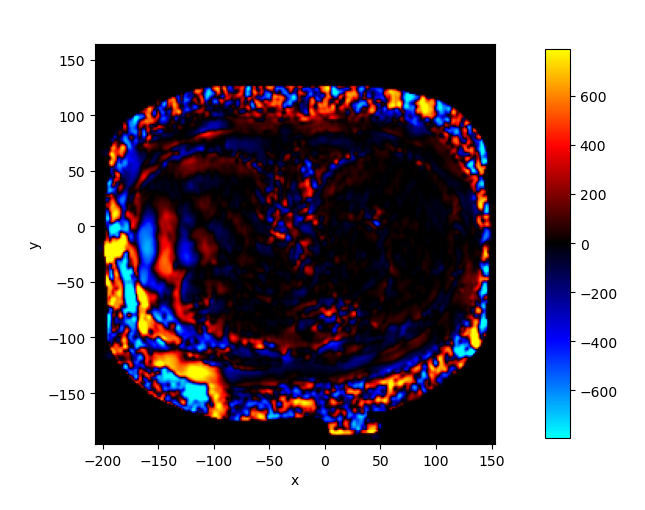

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


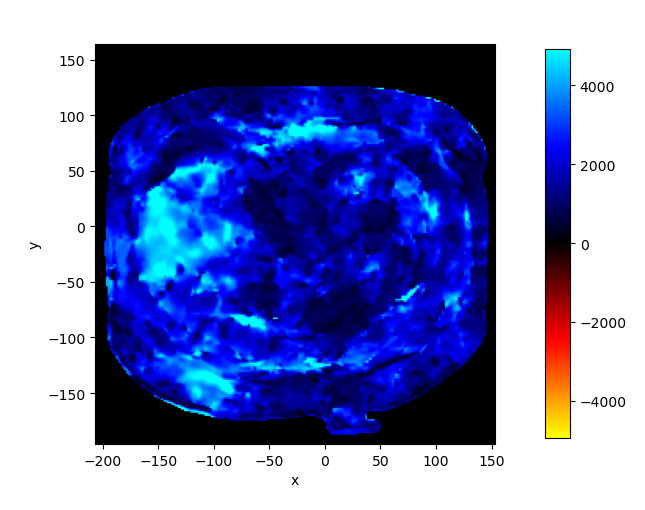

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [38]:
%autoreload
example = mre_pinn.data.MREExample.from_patient(patient)
example.view()

<IPython.core.display.Javascript object>


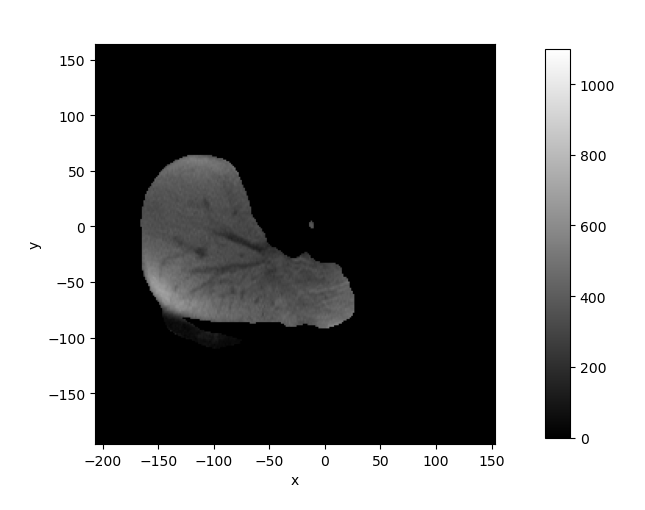

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


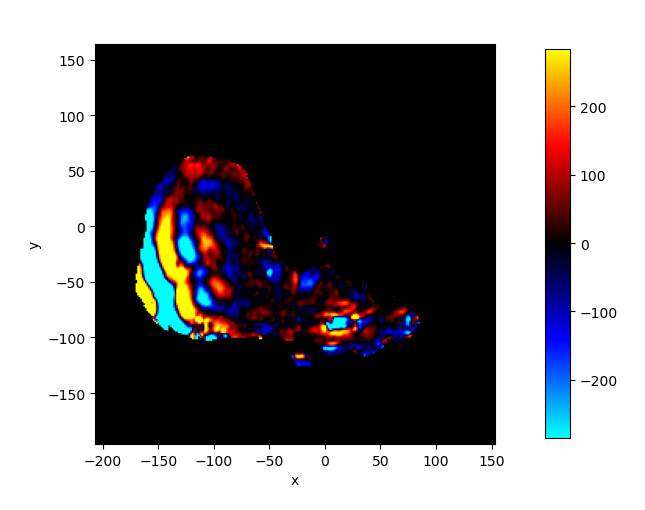

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


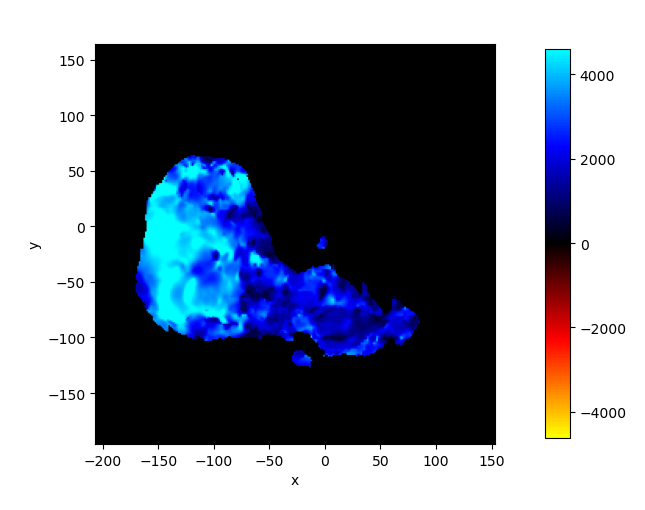

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [39]:
example.view(mask=True)

In [40]:
example.save_xarrays('../data/NAFLD_test/')

Writing ../data/NAFLD_test/0006/anat.nc
Writing ../data/NAFLD_test/0006/wave.nc
Writing ../data/NAFLD_test/0006/mre.nc
Writing ../data/NAFLD_test/0006/mre_mask.nc
Writing ../data/NAFLD_test/0006/anat_mask.nc


In [41]:
%autoreload
example = mre_pinn.data.MREExample.from_xarrays('../data/NAFLD_test/', '0006')

Loading ../data/NAFLD_test/0006/anat.nc
Loading ../data/NAFLD_test/0006/wave.nc
Loading ../data/NAFLD_test/0006/mre.nc
Loading ../data/NAFLD_test/0006/mre_mask.nc
Loading ../data/NAFLD_test/0006/anat_mask.nc


## Process images for a patient cohort

In [42]:
with open('/ocean/projects/asc170022p/shared/Data/MRE/gold.txt') as f:
    patient_ids = [line.split('.')[0].split('_')[1] for line in f]

len(patient_ids)

181

In [43]:
%autoreload
cohort = mre_pinn.data.ImagingCohort(patient_ids='{' + ','.join(patient_ids) + '}')
len(cohort)

/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0830 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0838 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0846 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0860 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0872 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1474 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1483 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1495 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1504 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1526 

155

In [44]:
%%time
cohort.load_images()

  0%|          | 0/155 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre.nii
  1%|          | 1/155 [00:00<01:06,  2.32it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0900/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre.nii
  7%|▋         | 11/155 [00:06<01:29,  1.62it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t2.nii
Loading /ocean/projects

 14%|█▎        | 21/155 [00:10<01:10,  1.90it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre.nii
 14%|█▍        | 22/155 [00:11<01:00,  2.18it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1108/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre.nii
 21%|██        | 32/155 [00:15<00:52,  2.32it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t2.nii
Loading /ocean/projects

 27%|██▋       | 42/155 [00:18<00:42,  2.67it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre.nii
 28%|██▊       | 43/155 [00:19<00:36,  3.10it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1343/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

 34%|███▍      | 53/155 [00:22<00:37,  2.73it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/mre.nii
 35%|███▍      | 54/155 [00:22<00:40,  2.52it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1448/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

 41%|████▏     | 64/155 [00:25<00:25,  3.50it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/mre.nii
 42%|████▏     | 65/155 [00:25<00:25,  3.52it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0135/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFT

 48%|████▊     | 75/155 [00:28<00:24,  3.29it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/mre.nii
 49%|████▉     | 76/155 [00:29<00:26,  3.03it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0415/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFT

 55%|█████▌    | 86/155 [00:31<00:18,  3.73it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0461/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0461/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0461/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0461/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0461/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0461/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0461/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0461/mre.nii
 56%|█████▌    | 87/155 [00:31<00:16,  4.16it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0491/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/mre.nii
 63%|██████▎   | 97/155 [00:34<00:12,  4.70it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 69%|██████▉   | 107/155 [00:36<00:10,  4.74it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0717/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0717/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0717/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0717/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0717/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0717/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0717/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0717/mre.nii
 70%|██████▉   | 108/155 [00:36<00:09,  4.99it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0727/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1699/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1699/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1699/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1699/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1699/mre.nii
 76%|███████▌  | 118/155 [00:38<00:07,  5.26it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t2.nii
Loading /ocean/projects/asc17002

 83%|████████▎ | 128/155 [00:40<00:04,  5.41it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/mre.nii
 83%|████████▎ | 129/155 [00:40<00:04,  5.26it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1790/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/mre.nii
 90%|████████▉ | 139/155 [00:42<00:03,  5.01it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t2.nii
Loading /ocean/projects/asc17002

 96%|█████████▌| 149/155 [00:44<00:01,  4.90it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1967/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1967/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1967/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1967/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1967/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1967/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1967/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1967/mre.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1979/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1979/t1_pre_water.nii
Loading /ocean/projects

In [45]:
%%time
cohort.preprocess_images()

Loading segmentation model
  0%|          | 0/155 [00:00<?, ?it/s]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.9609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560157cab940)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1921563
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.538 -45.776 158.963)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.125 -255.363 22.1128)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat 

  1%|          | 1/155 [00:50<2:10:37, 50.89s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560157caa570)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2161832
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49001 -40.622 97.0866)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.124 -235.236 -2.96341)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

  1%|▏         | 2/155 [01:33<1:57:19, 46.01s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56015777eac0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2402081
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -14.1432 -20.0002 129.457)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.765 -219.622 1.80725)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

  2%|▏         | 3/155 [02:21<1:59:14, 47.07s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601578000d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2641885
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -14.7098 -19.9938 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -194.352 -199.636 -43.355)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

  3%|▎         | 4/155 [03:02<1:52:18, 44.63s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e51f2f60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2882192
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -37.9233 -22.5813 32.6316)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -227.555 -212.213 -85.8186)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

  3%|▎         | 5/155 [03:48<1:52:35, 45.04s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56015777ee40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3122533
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -41.8383 28.0817 110.295)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.516 -141.596 1.04483)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

  4%|▍         | 6/155 [04:32<1:50:41, 44.58s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560157808d40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3362560
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.663 -24.294 28.3346)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -169.969 -213.926 -80.9155)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

  5%|▍         | 7/155 [05:15<1:48:59, 44.19s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560157db67b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3602710
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.9535 -38.9105 96.2272)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -195.623 -258.487 -13.0228)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

  5%|▌         | 8/155 [05:59<1:47:44, 43.98s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e51b7880)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3842763
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -21.5945 -44.0665 -12.9166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.181 -253.653 -122.167)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

  6%|▌         | 9/155 [06:43<1:47:02, 43.99s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560157787e10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4082715
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.26324 -38.9073 51.5384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.885 -238.529 -76.1118)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

  6%|▋         | 10/155 [07:31<1:49:41, 45.39s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010b6d4410)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4322990
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.60875 -21.7222 1.6932)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.033 -201.364 -135.156)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

  7%|▋         | 11/155 [08:22<1:52:48, 47.00s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e93c0950)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4563302
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4128 -19.9938 10.2872)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -190.055 -199.636 -89.7623)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

  8%|▊         | 12/155 [09:03<1:47:50, 45.25s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.986328125
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e51f2f60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4803363
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.83825 -20.0048 155.741)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.693 -259.536 37.291)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

  8%|▊         | 13/155 [09:49<1:47:22, 45.37s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.943359375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600df94f5d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5043388
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -0.962995 -28.591 250.919)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -190.595 -218.223 132.469)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

  9%|▉         | 14/155 [10:35<1:47:09, 45.60s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e9524480)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5283531
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.18974 -20.0002 54.976)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -195.432 -219.622 -45.0698)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 10%|▉         | 15/155 [11:17<1:43:46, 44.47s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fd389bd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5523735
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4193 -20.0002 54.1166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -210.041 -219.622 -55.1335)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 10%|█         | 16/155 [11:59<1:41:45, 43.92s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010be75790)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5763962
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.2057 -40.6252 64.4294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.371 -260.202 -44.8204)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 11%|█         | 17/155 [12:43<1:40:46, 43.82s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.9921875
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e51a1c80)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6003922
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -1.82199 -34.607 105.681)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.454 -224.239 -21.9685)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 12%|█▏        | 18/155 [13:31<1:42:48, 45.02s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010b6d4830)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6243651
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 14.223 -45.776 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.354 -265.353 -61.7554)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 12%|█▏        | 19/155 [14:16<1:42:16, 45.12s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e51e73a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6483964
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.5188 -56.0952 83.7631)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -194.068 -265.682 -54.9869)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 13%|█▎        | 20/155 [15:04<1:43:21, 45.93s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010b6b5570)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6724111
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -29.32 -27.513 97.0866)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -248.897 -247.09 -30.5636)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 14%|█▎        | 21/155 [15:52<1:43:49, 46.49s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560157814b60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6964129
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -38.7835 -38.9105 152.733)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -248.37 -248.497 52.683)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 14%|█▍        | 22/155 [16:33<1:39:26, 44.86s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.974609375 -0.958984375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e3fbd020)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7204331
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -12.777 -60.815 86.9886)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -232.354 -280.392 -45.2497)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 15%|█▍        | 23/155 [17:22<1:41:27, 46.12s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010be6b890)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7444497
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -12.1382 -38.9073 51.5384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.76 -238.529 -57.7114)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 15%|█▌        | 24/155 [18:05<1:38:45, 45.23s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010d341410)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7684466
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.755999 -35.466 -4.3226)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -188.876 -225.098 -122.773)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 16%|█▌        | 25/155 [18:50<1:37:46, 45.13s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560159296dc0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7924664
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.63424 -33.7438 63.57)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.998 -223.376 -54.8798)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 17%|█▋        | 26/155 [19:35<1:37:16, 45.25s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fe76eec0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8164893
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 33.413 -23.434 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -156.219 -213.066 -70.602)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 17%|█▋        | 27/155 [20:18<1:34:52, 44.47s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600df956dc0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8405107
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 5.04649 -42.3475 6.8496)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.54 -251.934 -111.601)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 18%|█▊        | 28/155 [21:03<1:34:18, 44.55s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c5dbac0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8645381
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 18.806 -19.994 240.72)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.771 -239.571 122.27)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultI

 19%|█▊        | 29/155 [21:48<1:34:07, 44.82s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010d4feab0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8885332
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.432 -20.856 23.1782)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.064 -210.488 -86.0716)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 19%|█▉        | 30/155 [22:31<1:32:11, 44.25s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600df953cf0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9125429
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.61475 -54.3732 20.6)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -227.926 -283.914 -79.4498)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 20%|██        | 31/155 [23:12<1:29:28, 43.29s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010b6d43c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9365736
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.7755 -61.5405 22.6053)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -198.811 -271.127 -77.4448)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 21%|██        | 32/155 [23:53<1:26:57, 42.42s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560159296de0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9605940
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 28.257 -19.997 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.375 -209.629 -5.28798)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 21%|██▏       | 33/155 [24:35<1:26:14, 42.42s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600ed8716b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9845742
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.6275 -75.8605 195.918)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.904 -315.392 68.2679)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 22%|██▏       | 34/155 [25:22<1:28:12, 43.74s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e8adeaa0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10086009
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.98225 -56.0952 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.569 -265.682 -61.4027)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 23%|██▎       | 35/155 [26:02<1:25:31, 42.76s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010b6c9040)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10326226
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -2.68851 -38.2655 182.812)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -202.311 -237.888 73.562)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 23%|██▎       | 36/155 [26:47<1:26:00, 43.36s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fe757df0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10566424
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.413 -46.635 176.438)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -229.99 -266.212 48.788)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 24%|██▍       | 37/155 [27:37<1:28:58, 45.24s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c6177b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10806733
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.979 -19.997 20.6)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.611 -209.629 -88.6494)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Result

 25%|██▍       | 38/155 [28:19<1:26:37, 44.42s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010d514f30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11046855
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8158 -32.0312 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.806 -231.653 -52.5553)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 25%|██▌       | 39/155 [29:02<1:24:50, 43.88s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010af326d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11286704
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -26.0163 85.9144)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.026 -225.638 -14.1356)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 26%|██▌       | 40/155 [29:43<1:22:21, 42.97s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.984375 -0.982421875
Registering t1_pre_out to mre_raw
ParameterObject (0x56010af2bbe0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11526673
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 17.6577 -62.6802 192.48)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.919 -282.257 64.83)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Result

 26%|██▋       | 41/155 [30:30<1:24:01, 44.23s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c43ee80)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11766871
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.631 -19.997 71.3046)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.001 -209.629 -37.9452)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 27%|██▋       | 42/155 [31:13<1:22:43, 43.92s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e925c400)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12006799
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 42.2908 -27.1613 218.262)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -147.341 -216.793 99.8118)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 28%|██▊       | 43/155 [31:58<1:22:46, 44.35s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010af27420)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12246941
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 38.5658 -45.7823 36.9286)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.056 -245.404 -81.5208)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 28%|██▊       | 44/155 [32:44<1:22:38, 44.67s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c4572d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12486992
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.5475 -44.0665 143.494)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.134 -253.653 15.844)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 29%|██▉       | 45/155 [33:32<1:23:51, 45.74s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600ed883290)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12726967
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 26.827 -48.354 195.918)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.76 -257.941 77.468)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Result

 30%|██▉       | 46/155 [34:17<1:22:28, 45.40s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601577fce30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12967178
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 25.6747 -20.0002 80.758)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -173.947 -219.622 -46.8922)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 30%|███       | 47/155 [35:04<1:22:39, 45.92s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600ed868590)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13207528
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 17.2235 -12.9335 129.084)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -172.409 -202.566 1.43404)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 31%|███       | 48/155 [35:51<1:22:49, 46.44s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601577fc9e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13447701
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 48.0167 -37.1913 151.229)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.16 -246.368 41.979)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 32%|███▏      | 49/155 [36:15<1:10:09, 39.71s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010af4f5f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13687788
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.928 -19.997 33.491)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -177.704 -209.629 -66.5591)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 32%|███▏      | 50/155 [36:56<1:10:08, 40.08s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600f9cf5c40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13927604
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -13.854 -19.997 52.3978)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -203.486 -209.629 -66.0524)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 33%|███▎      | 51/155 [37:42<1:12:12, 41.65s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c436f50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14167664
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.502 -57.592 161.971)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -218.039 -287.133 25.1208)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 34%|███▎      | 52/155 [38:31<1:15:24, 43.93s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e6cabb90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14407812
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.366 -19.997 24.897)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.266 -209.629 -84.3524)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 34%|███▍      | 53/155 [39:14<1:14:12, 43.66s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c60d760)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14648164
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.53776 -19.9938 182.167)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -183.18 -199.636 54.5169)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 35%|███▍      | 54/155 [40:01<1:15:19, 44.74s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c439c90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14888383
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.19301 -19.997 34.3504)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -185.439 -209.629 -74.8994)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 35%|███▌      | 55/155 [40:44<1:13:34, 44.14s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600f9cc9b20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15128684
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -36.3282 50.679)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.991 -245.915 -67.7708)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 36%|███▌      | 56/155 [41:29<1:13:13, 44.38s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c439de0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15368963
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8125 -41.4885 59.273)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.774 -251.075 -59.1772)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 37%|███▋      | 57/155 [42:14<1:13:03, 44.73s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560157788480)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15608929
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.852 -19.998 82.9065)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.78 -209.63 -35.5437)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 37%|███▋      | 58/155 [43:00<1:12:40, 44.95s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e3fbd090)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15849082
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 38%|███▊      | 59/155 [43:41<1:09:56, 43.71s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010af392f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16088985
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.33075 -38.0473 72.164)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.291 -237.669 -37.0858)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 39%|███▊      | 60/155 [44:26<1:10:03, 44.25s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010be63830)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16329168
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.4288 -21.7128 14.5842)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.061 -211.345 -85.4225)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 39%|███▉      | 61/155 [45:09<1:08:36, 43.80s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e928cda0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16568997
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.33075 -38.0473 72.164)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.291 -237.669 -37.0858)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 40%|████      | 62/155 [45:52<1:07:22, 43.47s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fd389b40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16809153
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.61825 -19.9938 47.2414)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.024 -199.636 -62.0087)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 41%|████      | 63/155 [46:35<1:06:28, 43.36s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010af394b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17048800
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 16.837 -22.471 223.653)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -172.795 -212.103 123.603)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 41%|████▏     | 64/155 [47:16<1:04:45, 42.69s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e928cda0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17288916
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.542 -51.505 149.506)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -225.119 -271.082 21.856)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 42%|████▏     | 65/155 [48:04<1:06:29, 44.32s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600ed883210)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17529095
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.96 -24.294 79.0392)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -165.672 -213.926 -39.4106)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 43%|████▎     | 66/155 [48:49<1:06:10, 44.61s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdc06400)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17769096
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.886 -37.185 36.0692)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -215.518 -226.817 -82.381)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 43%|████▎     | 67/155 [49:34<1:05:32, 44.69s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010af27560)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18008554
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -8.54324 -20.0002 90.1312)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -217.72 -229.177 -28.319)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 44%|████▍     | 68/155 [49:59<56:08, 38.72s/it]  Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601577889e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18248792
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.6682 -40.8333 134.923)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.29 -240.455 16.473)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 45%|████▍     | 69/155 [50:44<58:22, 40.73s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600df94f5d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18488691
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8763 -20.0033 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.508 -209.635 -5.28835)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 45%|████▌     | 70/155 [51:27<58:31, 41.32s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdb51b60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18728986
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.886 -38.904 61.8512)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -225.508 -238.526 -38.1988)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 46%|████▌     | 71/155 [52:08<57:46, 41.27s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600f9d00d90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18969128
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -30.1862 -48.3602 44.6632)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -229.808 -247.982 -64.5866)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 46%|████▋     | 72/155 [52:51<57:46, 41.77s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010af392f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19209187
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -21.589 -19.997 -25.8076)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.221 -209.629 -144.258)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 47%|████▋     | 73/155 [53:36<58:31, 42.83s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010d504e00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19449412
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.25675 -19.9938 45.5226)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.899 -199.636 -54.5272)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 48%|████▊     | 74/155 [54:18<57:06, 42.30s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010bb4de20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19689507
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.39776 -20.8528 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.04 -200.495 -74.2937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 48%|████▊     | 75/155 [54:58<55:49, 41.87s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdc06b30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19929672
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.36751 -35.0425 283.247)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.954 -244.629 155.597)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 49%|████▉     | 76/155 [55:46<57:24, 43.61s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fe791ba0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20169740
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.62775 -48.3602 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.994 -247.982 -70.6027)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 50%|████▉     | 77/155 [56:29<56:17, 43.30s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010bb4dc20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20409697
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 9.56149 -50.0795 217.832)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.98 -279.621 71.7833)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 50%|█████     | 78/155 [57:21<59:00, 45.98s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560108683030)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20649975
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.4835 -42.1325 134.685)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.103 -251.719 7.03504)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 51%|█████     | 79/155 [58:09<58:56, 46.53s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010be63830)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20890060
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.0068 -19.9938 13.7248)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.639 -209.626 -104.725)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 52%|█████▏    | 80/155 [58:55<57:56, 46.35s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010b6bbad0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21130370
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.889 -44.343 232.554)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.688 -263.92 104.904)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultI

 52%|█████▏    | 81/155 [59:43<57:47, 46.86s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601086cd270)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21370662
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 53.182 -44.863 234.793)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -166.395 -264.44 125.543)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultI

 53%|█████▎    | 82/155 [1:00:26<55:36, 45.71s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdbbcbd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21610966
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.026 -19.137 75.6016)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -224.648 -218.759 -24.4484)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 54%|█████▎    | 83/155 [1:01:07<53:12, 44.34s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdbeb7c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21851006
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.604 -24.294 65.2888)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -217.236 -213.926 -53.1614)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 54%|█████▍    | 84/155 [1:01:52<52:48, 44.63s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010bb50070)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22090705
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49325 -26.0098 37.788)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.149 -205.652 -71.4622)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 55%|█████▍    | 85/155 [1:02:35<51:32, 44.18s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdbbc8e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22330887
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -26.745 -19.997 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.377 -209.629 -74.2937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 55%|█████▌    | 86/155 [1:03:17<49:49, 43.33s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdbbc8e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22570969
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.334 -25.153 42.9444)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.28 -219.767 -57.1057)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resul

 56%|█████▌    | 87/155 [1:03:58<48:18, 42.62s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010b6be610)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22811238
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.663 -19.997 -10.3384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -169.969 -209.629 -119.589)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 57%|█████▋    | 88/155 [1:04:41<47:44, 42.76s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600f1250aa0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23051528
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.749494 -32.0345 -23.2294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -203.855 -236.639 -141.68)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 57%|█████▋    | 89/155 [1:05:26<47:52, 43.53s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010d4e5fb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23291719
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.33751 -51.4485 180.367)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -222.914 -271.025 43.517)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 58%|█████▊    | 90/155 [1:06:17<49:38, 45.82s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010d504e00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23531812
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.759237 -18.2748 12.8654)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.883 -197.917 -87.1847)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 59%|█████▊    | 91/155 [1:06:58<47:20, 44.39s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601360b6180)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23771652
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -32.4448 -19.9938 163.651)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -212.087 -199.636 45.2009)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 59%|█████▉    | 92/155 [1:07:43<46:50, 44.62s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010c41ce10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24011571
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8158 -44.0632 10.2872)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.806 -243.685 -98.9629)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 60%|██████    | 93/155 [1:08:26<45:28, 44.01s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010d5174f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24251882
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -7.83799 -56.951 67.867)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.498 -231.611 -13.783)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 61%|██████    | 94/155 [1:09:02<42:26, 41.75s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560138eed0a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24492002
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.12225 -20.0002 43.8038)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.744 -219.622 -65.4464)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 61%|██████▏   | 95/155 [1:09:45<42:01, 42.02s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600ed933ac0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24731683
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 32.713 -38.9 93.725)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.864 -258.477 -33.9252)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Result

 62%|██████▏   | 96/155 [1:10:33<42:57, 43.69s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601086a6c70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24972001
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -0.107254 -32.0312 13.7248)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -199.729 -231.653 -86.3253)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  

 63%|██████▎   | 97/155 [1:11:13<41:20, 42.76s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdbbca30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25212174
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.07851 -41.8775 179.975)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -212.665 -251.464 61.525)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 63%|██████▎   | 98/155 [1:11:59<41:20, 43.51s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560135ca8560)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25452414
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 5.04974 -71.5642 42.085)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.537 -281.151 -76.3652)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 64%|██████▍   | 99/155 [1:12:44<41:07, 44.06s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56013c2713d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25692618
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.749494 -20.0035 70.4452)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.837 -229.59 -38.8049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 65%|██████▍   | 100/155 [1:13:27<40:06, 43.75s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600ed846cf0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25932673
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.26324 -20.0002 12.8654)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.885 -219.622 -105.585)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  

 65%|██████▌   | 101/155 [1:14:12<39:44, 44.15s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010b6d5130)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26172866
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -30.1862 -48.3602 36.0692)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -239.773 -257.947 -82.381)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 66%|██████▌   | 102/155 [1:14:57<39:15, 44.44s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdbbdee0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26412879
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.73775 -59.0623 197.163)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.849 -268.649 69.513)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 66%|██████▋   | 103/155 [1:15:45<39:24, 45.48s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560108683030)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26653024
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.17474 -20.0002 125.288)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.447 -219.622 -20.7622)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 67%|██████▋   | 104/155 [1:16:39<40:44, 47.92s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56013d6a5670)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26893269
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.98225 -58.6732 -14.6354)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.604 -258.295 -123.886)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
 

 68%|██████▊   | 105/155 [1:17:22<38:41, 46.43s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56013d418c60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27133454
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.931 -63.743 123.493)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.646 -283.32 5.04284)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 68%|██████▊   | 106/155 [1:18:07<37:38, 46.08s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56013b44e370)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27373619
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.18974 -56.9543 49.8196)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.397 -266.541 -68.6298)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 69%|██████▉   | 107/155 [1:18:53<36:55, 46.16s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600fdbbdee0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27613914
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -13.0015 -58.6765 66.1482)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -222.588 -268.263 -33.9018)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  

 70%|██████▉   | 108/155 [1:19:36<35:19, 45.11s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560108683030)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27854093
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.67924 -56.4583 165.131)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.301 -256.08 46.681)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 70%|███████   | 109/155 [1:20:25<35:24, 46.18s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601380a2e90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28094148
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.759237 -21.7128 32.6316)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.883 -201.355 -67.4179)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  

 71%|███████   | 110/155 [1:21:08<33:59, 45.33s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560138ef0a30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28334144
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.541 -19.997 23.1782)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -193.173 -209.629 -76.8716)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 72%|███████▏  | 111/155 [1:21:52<32:55, 44.90s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e6cabb70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28574388
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 21.3777 -31.1723 26.6158)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.244 -230.794 -73.434)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 72%|███████▏  | 112/155 [1:22:36<32:03, 44.73s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600e51f6e20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28814562
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -17.2953 -20.0002 58.4136)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.917 -219.622 -50.7891)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  

 73%|███████▎  | 113/155 [1:23:23<31:44, 45.34s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601349a0910)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29054786
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49001 -19.997 16.303)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.142 -209.629 -92.9471)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 74%|███████▎  | 114/155 [1:24:09<31:14, 45.71s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560142816f10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29295051
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 14.5027 -39.7663 50.679)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -185.119 -239.388 -58.5711)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 74%|███████▍  | 115/155 [1:24:56<30:43, 46.08s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560142adbc10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29535012
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8763 -20.0033 59.273)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.498 -219.625 -49.9771)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 75%|███████▍  | 116/155 [1:25:43<30:08, 46.38s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601419ead30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29774820
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.97576 -53.5098 -24.9482)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.618 -233.152 -138.798)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
 

 75%|███████▌  | 117/155 [1:26:31<29:41, 46.88s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600f1202140)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30015111
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.7343 -46.5652 0.2875)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -225.356 -246.187 -108.963)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 76%|███████▌  | 118/155 [1:27:18<28:53, 46.85s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601405f9100)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30255421
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.4065 -20.0035 70.4452)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.993 -229.59 -38.8049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 77%|███████▋  | 119/155 [1:28:04<27:59, 46.66s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601420bd0c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30495530
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 29.1127 -20.0002 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.474 -229.587 -79.8024)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 77%|███████▋  | 120/155 [1:28:54<27:39, 47.40s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560142b5d9b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30735794
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.6597 -45.7823 89.352)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -179.962 -245.404 -33.6978)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 78%|███████▊  | 121/155 [1:29:44<27:22, 48.31s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560143cca690)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30976051
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 18.52 -51.791 149.796)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.057 -271.368 22.1459)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 79%|███████▊  | 122/155 [1:30:36<27:11, 49.44s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601420bcb70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31216205
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49325 -19.9938 12.006)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.149 -199.636 -88.0435)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 79%|███████▉  | 123/155 [1:31:20<25:30, 47.83s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56013d49c920)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31456457
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8668 -19.9938 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.499 -209.626 3.91183)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 80%|████████  | 124/155 [1:32:04<24:09, 46.75s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560145fa5aa0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31696590
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 2.47176 -19.1402 64.4294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -197.15 -218.762 -54.0204)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 81%|████████  | 125/155 [1:32:53<23:36, 47.22s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560143ccec40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31936771
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 29.9685 -27.7375 86.7738)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -179.618 -237.324 -22.4763)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 81%|████████▏ | 126/155 [1:33:40<22:50, 47.26s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560143cca690)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32176392
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -2.05699 -34.893 67.9451)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.689 -224.525 -27.5049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 82%|████████▏ | 127/155 [1:34:23<21:26, 45.96s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5600f1280ec0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32415908
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.432 -19.997 7.709)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.064 -209.629 -92.3411)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 83%|████████▎ | 128/155 [1:35:07<20:24, 45.33s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560146632f10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32655905
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4193 -23.4373 7.709)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -210.041 -223.059 -110.741)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 83%|████████▎ | 129/155 [1:35:55<20:02, 46.25s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56010bb7abc0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32896069
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.416 -19.997 28.3346)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.048 -209.629 -71.7155)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 84%|████████▍ | 130/155 [1:36:40<19:01, 45.66s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560138eecfe0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33135990
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 30.838 -58.667 167.271)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -188.739 -278.244 30.421)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 85%|████████▍ | 131/155 [1:37:33<19:12, 48.03s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014139cca0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33375940
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 27.6775 -50.0825 121.436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.945 -249.705 -24.6142)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 85%|████████▌ | 132/155 [1:38:31<19:35, 51.12s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56013d49ea20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33615657
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 34.2688 -20.0002 93.649)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -165.353 -219.622 -34.0067)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 86%|████████▌ | 133/155 [1:39:23<18:46, 51.21s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560149cc8d70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33855740
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 22.2442 -19.9938 48.9602)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -157.398 -199.636 -60.2899)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 86%|████████▋ | 134/155 [1:40:10<17:27, 49.89s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014a476370)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34095331
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 13.6438 -57.8133 8.5684)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -185.978 -257.435 -109.882)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 87%|████████▋ | 135/155 [1:40:58<16:30, 49.54s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014a06aac0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34335242
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 13.65 -57.592 48.7453)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.927 -277.169 -78.9049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 88%|████████▊ | 136/155 [1:41:49<15:48, 49.91s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560138eecfe0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34575444
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.63424 -30.3068 42.9444)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.998 -219.939 -75.5058)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 88%|████████▊ | 137/155 [1:42:37<14:49, 49.40s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560145f1d900)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34815224
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 40.288 -19.997 71.3046)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -149.344 -209.629 -47.1456)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 89%|████████▉ | 138/155 [1:43:25<13:53, 49.01s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014b27baa0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35054877
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -37.1882 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.026 -236.81 -83.4937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 90%|████████▉ | 139/155 [1:44:12<12:51, 48.20s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.982421875 -0.994140625
Registering t1_pre_out to mre_raw
ParameterObject (0x560145f1d900)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35295117
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 20.8055 -62.9705 175.292)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -218.726 -302.502 38.4421)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  

 90%|█████████ | 140/155 [1:45:05<12:24, 49.66s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560146c854e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35535117
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.2665 -24.3005 138.624)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.889 -223.923 29.374)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 91%|█████████ | 141/155 [1:45:51<11:19, 48.56s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014d8daea0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35775430
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.6115 -52.6575 107.399)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -237.92 -292.189 7.3488)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Resu

 92%|█████████▏| 142/155 [1:46:34<10:11, 47.04s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560146c854e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36015575
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -26.9633 -44.9223 13.0803)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -246.54 -264.499 -100.769)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 92%|█████████▏| 143/155 [1:47:21<09:24, 47.00s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014eac4080)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36255645
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.0935 -25.7325 205.657)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.493 -235.319 91.807)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 93%|█████████▎| 144/155 [1:48:09<08:39, 47.25s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560140c47ad0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36495902
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 17.302 -19.994 67.867)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -202.275 -239.571 -64.3832)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Res

 94%|█████████▎| 145/155 [1:49:02<08:09, 48.98s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601420bd130)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36736134
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.0865 -44.9225 161.542)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -220.445 -284.454 29.2921)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 94%|█████████▍| 146/155 [1:49:54<07:29, 49.91s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014f1b6000)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36976471
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.5475 -50.0825 64.8591)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.134 -259.669 -76.5911)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 95%|█████████▍| 147/155 [1:50:50<06:52, 51.58s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014e73f3c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37216733
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 34.2752 -26.0098 54.1166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -155.357 -215.642 -68.9336)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 95%|█████████▌| 148/155 [1:51:40<05:58, 51.24s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56013d0947b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37456988
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.6375 -49.2225 53.0424)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -220.224 -258.809 -47.0076)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  

 96%|█████████▌| 149/155 [1:52:23<04:53, 48.86s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014b27bc10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37697309
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.9312 -25.1498 100.524)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -177.33 -214.411 -4.12585)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 97%|█████████▋| 150/155 [1:52:49<03:29, 41.83s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601533c5960)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37937592
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.2823 -20.0033 53.2572)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.96 -189.681 -55.9929)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 97%|█████████▋| 151/155 [1:53:32<02:48, 42.09s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x5601515acfb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 38177932
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.2823 -20.0033 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.96 -189.681 -83.4937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 98%|█████████▊| 152/155 [1:54:15<02:07, 42.53s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560155197950)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 38418276
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.83451 -37.1915 197.923)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.421 -246.778 93.2729)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 99%|█████████▊| 153/155 [1:55:00<01:26, 43.26s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x56014b906b40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 38658524
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.12225 -45.7823 161.542)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -235.663 -275.323 61.492)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

 99%|█████████▉| 154/155 [1:55:44<00:43, 43.41s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
0.99609375 -0.99609375
Registering t1_pre_out to mre_raw
ParameterObject (0x560155f3f430)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 38898834
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 16.225 -19.997 -75.6528)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -183.397 -219.619 -203.302)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (R

100%|██████████| 155/155 [1:56:35<00:00, 45.13s/it]
CPU times: user 4h 29min 50s, sys: 34min 36s, total: 5h 4min 27s
Wall time: 1h 56min 35s


In [48]:
%%time
dataset = mre_pinn.data.MREDataset.from_cohort(cohort)

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to

Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat 

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to

Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Con

Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat 

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
CPU times: user 3.01 s, sys: 1.32 s, total: 4.33 s
Wall time: 4.33 s


In [49]:
dataset.save_xarrays('../data/NAFLD2')

Writing ../data/NAFLD2/0898/anat.nc
Writing ../data/NAFLD2/0898/wave.nc
Writing ../data/NAFLD2/0898/mre.nc
Writing ../data/NAFLD2/0898/mre_mask.nc
Writing ../data/NAFLD2/0898/anat_mask.nc
Writing ../data/NAFLD2/0900/anat.nc
Writing ../data/NAFLD2/0900/wave.nc
Writing ../data/NAFLD2/0900/mre.nc
Writing ../data/NAFLD2/0900/mre_mask.nc
Writing ../data/NAFLD2/0900/anat_mask.nc
Writing ../data/NAFLD2/0929/anat.nc
Writing ../data/NAFLD2/0929/wave.nc
Writing ../data/NAFLD2/0929/mre.nc
Writing ../data/NAFLD2/0929/mre_mask.nc
Writing ../data/NAFLD2/0929/anat_mask.nc
Writing ../data/NAFLD2/0931/anat.nc
Writing ../data/NAFLD2/0931/wave.nc
Writing ../data/NAFLD2/0931/mre.nc
Writing ../data/NAFLD2/0931/mre_mask.nc
Writing ../data/NAFLD2/0931/anat_mask.nc
Writing ../data/NAFLD2/0932/anat.nc
Writing ../data/NAFLD2/0932/wave.nc
Writing ../data/NAFLD2/0932/mre.nc
Writing ../data/NAFLD2/0932/mre_mask.nc
Writing ../data/NAFLD2/0932/anat_mask.nc
Writing ../data/NAFLD2/0940/anat.nc
Writing ../data/NAFLD2/0

Writing ../data/NAFLD2/1344/anat.nc
Writing ../data/NAFLD2/1344/wave.nc
Writing ../data/NAFLD2/1344/mre.nc
Writing ../data/NAFLD2/1344/mre_mask.nc
Writing ../data/NAFLD2/1344/anat_mask.nc
Writing ../data/NAFLD2/1382/anat.nc
Writing ../data/NAFLD2/1382/wave.nc
Writing ../data/NAFLD2/1382/mre.nc
Writing ../data/NAFLD2/1382/mre_mask.nc
Writing ../data/NAFLD2/1382/anat_mask.nc
Writing ../data/NAFLD2/1395/anat.nc
Writing ../data/NAFLD2/1395/wave.nc
Writing ../data/NAFLD2/1395/mre.nc
Writing ../data/NAFLD2/1395/mre_mask.nc
Writing ../data/NAFLD2/1395/anat_mask.nc
Writing ../data/NAFLD2/1400/anat.nc
Writing ../data/NAFLD2/1400/wave.nc
Writing ../data/NAFLD2/1400/mre.nc
Writing ../data/NAFLD2/1400/mre_mask.nc
Writing ../data/NAFLD2/1400/anat_mask.nc
Writing ../data/NAFLD2/1404/anat.nc
Writing ../data/NAFLD2/1404/wave.nc
Writing ../data/NAFLD2/1404/mre.nc
Writing ../data/NAFLD2/1404/mre_mask.nc
Writing ../data/NAFLD2/1404/anat_mask.nc
Writing ../data/NAFLD2/1417/anat.nc
Writing ../data/NAFLD2/1

Writing ../data/NAFLD2/0496/wave.nc
Writing ../data/NAFLD2/0496/mre.nc
Writing ../data/NAFLD2/0496/mre_mask.nc
Writing ../data/NAFLD2/0496/anat_mask.nc
Writing ../data/NAFLD2/0509/anat.nc
Writing ../data/NAFLD2/0509/wave.nc
Writing ../data/NAFLD2/0509/mre.nc
Writing ../data/NAFLD2/0509/mre_mask.nc
Writing ../data/NAFLD2/0509/anat_mask.nc
Writing ../data/NAFLD2/0510/anat.nc
Writing ../data/NAFLD2/0510/wave.nc
Writing ../data/NAFLD2/0510/mre.nc
Writing ../data/NAFLD2/0510/mre_mask.nc
Writing ../data/NAFLD2/0510/anat_mask.nc
Writing ../data/NAFLD2/0516/anat.nc
Writing ../data/NAFLD2/0516/wave.nc
Writing ../data/NAFLD2/0516/mre.nc
Writing ../data/NAFLD2/0516/mre_mask.nc
Writing ../data/NAFLD2/0516/anat_mask.nc
Writing ../data/NAFLD2/0525/anat.nc
Writing ../data/NAFLD2/0525/wave.nc
Writing ../data/NAFLD2/0525/mre.nc
Writing ../data/NAFLD2/0525/mre_mask.nc
Writing ../data/NAFLD2/0525/anat_mask.nc
Writing ../data/NAFLD2/0564/anat.nc
Writing ../data/NAFLD2/0564/wave.nc
Writing ../data/NAFLD2/0

Writing ../data/NAFLD2/1798/wave.nc
Writing ../data/NAFLD2/1798/mre.nc
Writing ../data/NAFLD2/1798/mre_mask.nc
Writing ../data/NAFLD2/1798/anat_mask.nc
Writing ../data/NAFLD2/1806/anat.nc
Writing ../data/NAFLD2/1806/wave.nc
Writing ../data/NAFLD2/1806/mre.nc
Writing ../data/NAFLD2/1806/mre_mask.nc
Writing ../data/NAFLD2/1806/anat_mask.nc
Writing ../data/NAFLD2/1807/anat.nc
Writing ../data/NAFLD2/1807/wave.nc
Writing ../data/NAFLD2/1807/mre.nc
Writing ../data/NAFLD2/1807/mre_mask.nc
Writing ../data/NAFLD2/1807/anat_mask.nc
Writing ../data/NAFLD2/1819/anat.nc
Writing ../data/NAFLD2/1819/wave.nc
Writing ../data/NAFLD2/1819/mre.nc
Writing ../data/NAFLD2/1819/mre_mask.nc
Writing ../data/NAFLD2/1819/anat_mask.nc
Writing ../data/NAFLD2/1829/anat.nc
Writing ../data/NAFLD2/1829/wave.nc
Writing ../data/NAFLD2/1829/mre.nc
Writing ../data/NAFLD2/1829/mre_mask.nc
Writing ../data/NAFLD2/1829/anat_mask.nc
Writing ../data/NAFLD2/1839/anat.nc
Writing ../data/NAFLD2/1839/wave.nc
Writing ../data/NAFLD2/1

<IPython.core.display.Javascript object>


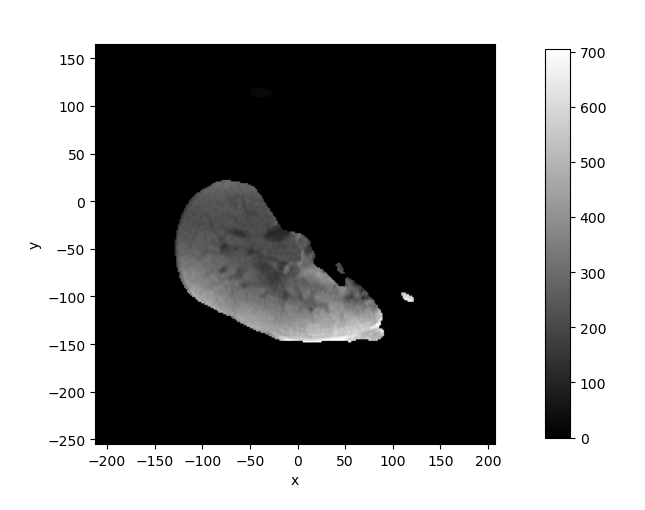

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


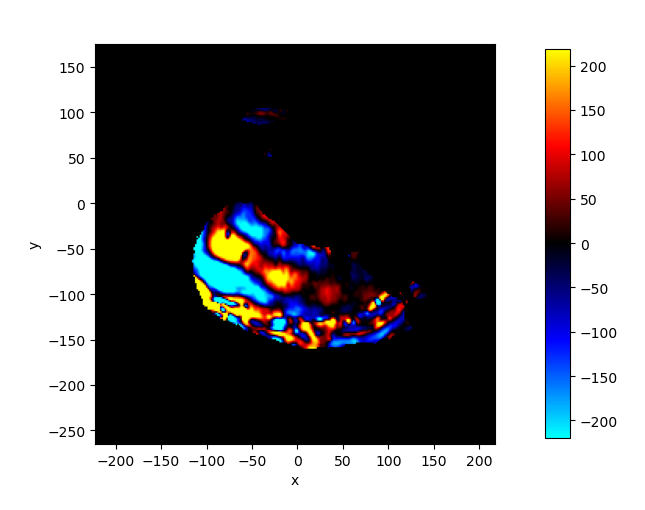

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


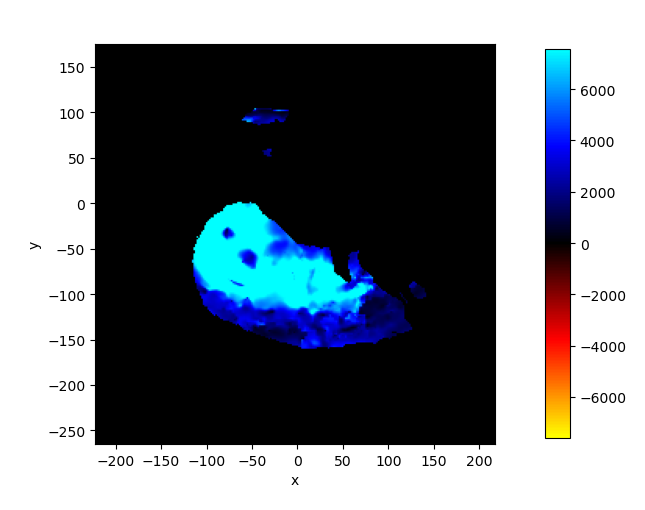

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [64]:
dataset[0].view(mask=True)

In [90]:
%autoreload
dataset = mre_pinn.data.MREDataset.from_xarrays('../data/NAFLD2')

Loading ../data/NAFLD2/1706/anat.nc
Loading ../data/NAFLD2/1706/wave.nc
Loading ../data/NAFLD2/1706/mre.nc
Loading ../data/NAFLD2/1706/mre_mask.nc
Loading ../data/NAFLD2/1706/anat_mask.nc
Loading ../data/NAFLD2/1230/anat.nc
Loading ../data/NAFLD2/1230/wave.nc
Loading ../data/NAFLD2/1230/mre.nc
Loading ../data/NAFLD2/1230/mre_mask.nc
Loading ../data/NAFLD2/1230/anat_mask.nc
Loading ../data/NAFLD2/1303/anat.nc
Loading ../data/NAFLD2/1303/wave.nc
Loading ../data/NAFLD2/1303/mre.nc
Loading ../data/NAFLD2/1303/mre_mask.nc
Loading ../data/NAFLD2/1303/anat_mask.nc
Loading ../data/NAFLD2/0415/anat.nc
Loading ../data/NAFLD2/0415/wave.nc
Loading ../data/NAFLD2/0415/mre.nc
Loading ../data/NAFLD2/0415/mre_mask.nc
Loading ../data/NAFLD2/0415/anat_mask.nc
Loading ../data/NAFLD2/1028/anat.nc
Loading ../data/NAFLD2/1028/wave.nc
Loading ../data/NAFLD2/1028/mre.nc
Loading ../data/NAFLD2/1028/mre_mask.nc
Loading ../data/NAFLD2/1028/anat_mask.nc
Loading ../data/NAFLD2/0932/anat.nc
Loading ../data/NAFLD2/0

Loading ../data/NAFLD2/0650/wave.nc
Loading ../data/NAFLD2/0650/mre.nc
Loading ../data/NAFLD2/0650/mre_mask.nc
Loading ../data/NAFLD2/0650/anat_mask.nc
Loading ../data/NAFLD2/0378/anat.nc
Loading ../data/NAFLD2/0378/wave.nc
Loading ../data/NAFLD2/0378/mre.nc
Loading ../data/NAFLD2/0378/mre_mask.nc
Loading ../data/NAFLD2/0378/anat_mask.nc
Loading ../data/NAFLD2/0029/anat.nc
Loading ../data/NAFLD2/0029/wave.nc
Loading ../data/NAFLD2/0029/mre.nc
Loading ../data/NAFLD2/0029/mre_mask.nc
Loading ../data/NAFLD2/0029/anat_mask.nc
Loading ../data/NAFLD2/1736/anat.nc
Loading ../data/NAFLD2/1736/wave.nc
Loading ../data/NAFLD2/1736/mre.nc
Loading ../data/NAFLD2/1736/mre_mask.nc
Loading ../data/NAFLD2/1736/anat_mask.nc
Loading ../data/NAFLD2/0693/anat.nc
Loading ../data/NAFLD2/0693/wave.nc
Loading ../data/NAFLD2/0693/mre.nc
Loading ../data/NAFLD2/0693/mre_mask.nc
Loading ../data/NAFLD2/0693/anat_mask.nc
Loading ../data/NAFLD2/0461/anat.nc
Loading ../data/NAFLD2/0461/wave.nc
Loading ../data/NAFLD2/0

Loading ../data/NAFLD2/0727/wave.nc
Loading ../data/NAFLD2/0727/mre.nc
Loading ../data/NAFLD2/0727/mre_mask.nc
Loading ../data/NAFLD2/0727/anat_mask.nc
Loading ../data/NAFLD2/0491/anat.nc
Loading ../data/NAFLD2/0491/wave.nc
Loading ../data/NAFLD2/0491/mre.nc
Loading ../data/NAFLD2/0491/mre_mask.nc
Loading ../data/NAFLD2/0491/anat_mask.nc
Loading ../data/NAFLD2/1205/anat.nc
Loading ../data/NAFLD2/1205/wave.nc
Loading ../data/NAFLD2/1205/mre.nc
Loading ../data/NAFLD2/1205/mre_mask.nc
Loading ../data/NAFLD2/1205/anat_mask.nc
Loading ../data/NAFLD2/1121/anat.nc
Loading ../data/NAFLD2/1121/wave.nc
Loading ../data/NAFLD2/1121/mre.nc
Loading ../data/NAFLD2/1121/mre_mask.nc
Loading ../data/NAFLD2/1121/anat_mask.nc
Loading ../data/NAFLD2/0648/anat.nc
Loading ../data/NAFLD2/0648/wave.nc
Loading ../data/NAFLD2/0648/mre.nc
Loading ../data/NAFLD2/0648/mre_mask.nc
Loading ../data/NAFLD2/0648/anat_mask.nc
Loading ../data/NAFLD2/1103/anat.nc
Loading ../data/NAFLD2/1103/wave.nc
Loading ../data/NAFLD2/1

Loading ../data/NAFLD2/1311/mre.nc
Loading ../data/NAFLD2/1311/mre_mask.nc
Loading ../data/NAFLD2/1311/anat_mask.nc
Loading ../data/NAFLD2/0164/anat.nc
Loading ../data/NAFLD2/0164/wave.nc
Loading ../data/NAFLD2/0164/mre.nc
Loading ../data/NAFLD2/0164/mre_mask.nc
Loading ../data/NAFLD2/0164/anat_mask.nc
Loading ../data/NAFLD2/1083/anat.nc
Loading ../data/NAFLD2/1083/wave.nc
Loading ../data/NAFLD2/1083/mre.nc
Loading ../data/NAFLD2/1083/mre_mask.nc
Loading ../data/NAFLD2/1083/anat_mask.nc
Loading ../data/NAFLD2/1807/anat.nc
Loading ../data/NAFLD2/1807/wave.nc
Loading ../data/NAFLD2/1807/mre.nc
Loading ../data/NAFLD2/1807/mre_mask.nc
Loading ../data/NAFLD2/1807/anat_mask.nc
Loading ../data/NAFLD2/2007/anat.nc
Loading ../data/NAFLD2/2007/wave.nc
Loading ../data/NAFLD2/2007/mre.nc
Loading ../data/NAFLD2/2007/mre_mask.nc
Loading ../data/NAFLD2/2007/anat_mask.nc
Loading ../data/NAFLD2/0734/anat.nc
Loading ../data/NAFLD2/0734/wave.nc
Loading ../data/NAFLD2/0734/mre.nc
Loading ../data/NAFLD2/07

In [96]:
dataset[[1,2,3]].examples

In [100]:
for train, test in dataset.k_fold_split(155):
    print(test.example_ids)

['1706']
['1230']
['1303']
['0415']
['1028']
['0932']
['1427']
['1106']
['0496']
['1940']
['1967']
['1271']
['1108']
['1980']
['1134']
['1077']
['0628']
['0900']
['1433']
['0234']
['1045']
['0509']
['1076']
['0219']
['0006']
['0401']
['1039']
['0929']
['1948']
['1395']
['1712']
['0655']
['0995']
['1851']
['1426']
['0747']
['0954']
['1448']
['0615']
['1853']
['1261']
['0510']
['1464']
['0659']
['1917']
['1793']
['0650']
['0378']
['0029']
['1736']
['0693']
['0461']
['1727']
['1839']
['0384']
['0604']
['0457']
['1806']
['0748']
['1456']
['1329']
['1144']
['1207']
['0704']
['2029']
['1341']
['0235']
['1296']
['1435']
['1896']
['0989']
['1123']
['0024']
['1899']
['1699']
['0740']
['1715']
['0931']
['1785']
['0291']
['0653']
['1337']
['1033']
['0964']
['0639']
['1786']
['1417']
['0344']
['0612']
['1671']
['1400']
['1110']
['0043']
['1903']
['0727']
['0491']
['1205']
['1121']
['0648']
['1103']
['0898']
['1819']
['0210']
['0047']
['1714']
['1790']
['0965']
['1344']
['0020']
['1404']
['1791']
[

In [71]:
dataset.example_ids = np.array(dataset.example_ids)